# Import Packages

In [52]:
import bs4 as bs
import pickle
import requests
import datetime as dt
import os

import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web
#import pandas.plotting
from pandas.plotting import register_matplotlib_converters
#import pandas.testing
from pandas.testing import assert_frame_equal
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib import style

import mplfinance  
from mpl_finance import candlestick_ohlc # mpl_finance is deprecated - need to update visualizations  
from concurrent import futures

import collections
from collections import Counter

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

style.use('ggplot')

# Parts 1-3: Using Stock Market Data

In [53]:
# This example uses Tesla ($TSLA) stock data from 1/1/2000 to current date.
# df = pd.read_csv('c:/Users/JCW/Desktop/Stock_Market_Data_Analysis/Company Data/tsla.csv', parse_dates = True, index_col = 'Date')
start = dt.datetime(2017,1,1)
end = dt.datetime.now()
x = 'TSLA'
df = web.DataReader(x, 'yahoo', start, end)

print(df.tail(10))

                  High         Low        Open       Close      Volume  \
Date                                                                     
2022-06-03  743.390015  700.250000  729.679993  703.549988  37348100.0   
2022-06-06  734.599976  703.049988  733.059998  714.840027  28068200.0   
2022-06-07  719.989990  690.280029  702.000000  716.659973  24269500.0   
2022-06-08  749.890015  717.530029  720.260010  725.599976  25403500.0   
2022-06-09  766.640015  717.979980  748.020020  719.119995  32163800.0   
2022-06-10  718.500000  683.739990  705.469971  696.690002  32512200.0   
2022-06-13  679.900024  644.049988  669.500000  647.210022  34255800.0   
2022-06-14  678.989990  635.210022  654.859985  662.669983  32662900.0   
2022-06-15  706.989990  654.450012  662.750000  699.000000  39532100.0   
2022-06-16  675.500000  640.809998  668.210022  643.940002  20466703.0   

             Adj Close  
Date                    
2022-06-03  703.549988  
2022-06-06  714.840027  
2022-06-07 

#### All stock data are indexed by date

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1374 entries, 2017-01-03 to 2022-06-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1374 non-null   float64
 1   Low        1374 non-null   float64
 2   Open       1374 non-null   float64
 3   Close      1374 non-null   float64
 4   Volume     1374 non-null   float64
 5   Adj Close  1374 non-null   float64
dtypes: float64(6)
memory usage: 75.1 KB


In [55]:
# Read data into csv.
df = web.DataReader(x, 'yahoo', start, end)
df.to_csv(x +'.csv')

def reading_data(x):
    df = pd.read_csv(x +'.csv', parse_dates = True, index_col = 'Date')

    # Moving average over 100 day period. You can alter the window to average over 30 days, or another time period.
    df['100ma'] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean()
    df.dropna(inplace = True)
    return df

df = reading_data(x)
print(df.tail())

                  High         Low        Open       Close      Volume  \
Date                                                                     
2022-06-10  718.500000  683.739990  705.469971  696.690002  32512200.0   
2022-06-13  679.900024  644.049988  669.500000  647.210022  34255800.0   
2022-06-14  678.989990  635.210022  654.859985  662.669983  32662900.0   
2022-06-15  706.989990  654.450012  662.750000  699.000000  39532100.0   
2022-06-16  675.500000  640.809998  668.210022  643.940002  20466703.0   

             Adj Close       100ma  
Date                                
2022-06-10  696.690002  878.819897  
2022-06-13  647.210022  875.335497  
2022-06-14  662.669983  871.999496  
2022-06-15  699.000000  869.550496  
2022-06-16  643.940002  866.689896  


# Part 4: Plot data using two plots (one for adjusted close price, one for volume).

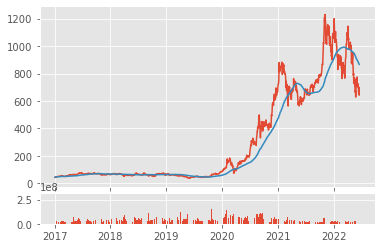

In [56]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

# Volume is shown in the subplot as a bar chart, and adj close is a line graph. Red is actual
# price, and blue is the 100 moving average.
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])
plt.show()

# Part 5: Getting S&P500 List

In [57]:
# Here we are using BeautifulSoup to scrape data from wikipedia, and save the current S&P500 list.
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find('table', {'id': 'constituents'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.find_all('td')[0].text.strip()
        tickers.append(ticker)
        
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)

    #print(tickers)
    if tickers.count('BRK.B') > 0 or tickers.count('BF.B') > 0:
        print('Yes, proceed to remove item  BRK.B & BF.B from the list of tickers: ')
        # drop item BRK.B. from list
        tickers.remove('BRK.B')
        tickers.remove('BF.B')
        print("Removed")
    else:
        print("Already removed")

    return tickers

# Part 6: Get data from Yahoo and call SP500 tickers list as sp500 and combining into one CSV file.

In [58]:
def get_data_from_yahoo(reload_sp500 = False):
    n = 0
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

# Take all of the data for stocks and store in a directory
# Working with API, parsing website, take entire dataset and store locally
# Here we will look at Adjusted Close, but we can look at other columns later
    if not os.path.exists('stock_dfs2'):
        os.makedirs('stock_dfs2')
    
    start = dt.datetime(2016,1,1)        
    end = dt.datetime.now()
    #end = dt.datetime(2020,7,24)

    # Grab all ticker data
    for ticker in tickers:
        #print(str( n )+ '. ' + ticker) 
        n += 1   
        if not os.path.exists('stock_dfs2/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs2/{}.csv'.format(ticker))
            except:
                print(f'Problems retrieving data for {ticker}. Skipping!')
            else:
                print('Already have {}'.format(ticker))

get_data_from_yahoo()

Problems retrieving data for BRK.B. Skipping!
Problems retrieving data for BF.B. Skipping!


In [59]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    mainDataSet = pd.DataFrame()

# Count in SP500 tickers list
    for count, ticker in enumerate(tickers):
        try:
            fileDataSet = pd.read_csv('stock_dfs2/{}.csv'.format(ticker))
            fileDataSet.set_index('Date', inplace = True)
            fileDataSet.rename(columns = {'Adj Close':ticker}, inplace = True)
            fileDataSet.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace = True)

            if mainDataSet.empty:
                mainDataSet = fileDataSet
            else:
                mainDataSet = mainDataSet.join(fileDataSet)
            #print(mainDataSet.head())
        except:
            print(f'Problems retrieving data for {ticker}. Skipping!')
    mainDataSet.to_csv('sp500_joined_closes.csv')
compile_data();

Problems retrieving data for BRK.B. Skipping!
Problems retrieving data for BF.B. Skipping!


In [60]:
#show the data
df = pd.read_csv('sp500_joined_closes.csv')
df.tail()

,Date,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
1602,2022-05-13,149.300003,60.009998,109.879997,153.500000,254.160004,286.769989,77.739998,84.998215,405.450012,...,205.830002,477.329987,66.269997,74.489998,83.910004,112.830002,336.859985,115.070000,53.560001,165.330002
1603,2022-05-16,150.500000,58.980000,109.709999,155.470001,253.789993,286.170013,78.000000,86.779999,402.859985,...,204.250000,473.959991,63.939999,74.830002,81.800003,112.180000,329.329987,115.120003,52.930000,165.500000
1604,2022-05-17,152.339996,60.349998,114.540001,154.779999,258.230011,291.070007,78.540001,88.629997,409.649994,...,207.210007,482.190002,66.400002,75.300003,84.040001,112.470001,344.579987,119.379997,54.900002,166.429993
1605,2022-05-18,148.929993,57.770000,112.739998,152.429993,240.460007,274.160004,77.919998,84.540001,397.880005,...,202.919998,465.779999,62.820000,74.889999,80.959999,109.459999,326.420013,116.449997,53.000000,158.860001
1606,2022-05-19,147.278595,58.340000,112.379997,151.125000,243.190002,276.095001,77.730003,83.410004,397.709991,...,201.238998,465.765015,63.889999,74.650002,81.489998,109.945000,325.285004,116.779999,52.029999,159.720001


# Part 8: Correlation Tables & Data Visualization Heat Map

           MMM       AOS       ABT      ABBV      ABMD       ACN      ATVI  \
MMM   1.000000  0.627513  0.168979  0.305798  0.513860  0.205439  0.443208   
AOS   0.627513  1.000000  0.678445  0.801038  0.618466  0.782886  0.693774   
ABT   0.168979  0.678445  1.000000  0.850860  0.642160  0.961595  0.748853   
ABBV  0.305798  0.801038  0.850860  1.000000  0.654806  0.891816  0.768794   
ABMD  0.513860  0.618466  0.642160  0.654806  1.000000  0.610351  0.678883   

           ADM      ADBE       ADP  ...       WTW       GWW      WYNN  \
MMM   0.181806  0.213004  0.214340  ...  0.216344  0.183092  0.714878   
AOS   0.756618  0.689916  0.710448  ...  0.662381  0.737337  0.266202   
ABT   0.770898  0.968977  0.945782  ...  0.956238  0.923571 -0.142068   
ABBV  0.906402  0.803248  0.864232  ...  0.814425  0.899830  0.001354   
ABMD  0.524839  0.659183  0.651562  ...  0.568852  0.685053  0.321057   

           XEL       XYL       YUM      ZBRA       ZBH      ZION       ZTS  
MMM   0.060747 

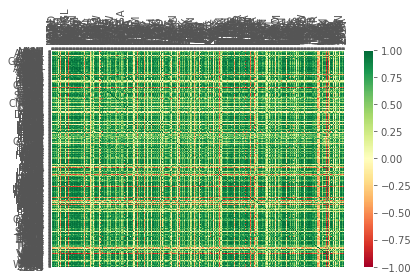

In [61]:
# Visualizing data from the SP500 close price csv 
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')

# Example of plotting one company close price over time for Apple (ticker = AAPL) 
#    df['AAPL'].plot()
#    plt.show()

# Create correlation table for all data in df for SP500 close price
    df_corr = df.corr()
    print(df_corr.head())
# Visualize inner values of dataframe (numpy array of columns and rows)
# Specify figure and define axes using parameters(111) : one subplot is 1x1 for plot 1)
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

# Define heatmap using a range from red to yellow to green
# Red = Negative, Yellow = Neutral, Green = Positive
# Colorbar for legend
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
# Build graph
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    column_labels = df_corr.columns
    row_labels = df_corr.index
# Make x labels vertical, set limit of colors (-1 = min, 1 = max)
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation = 90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()
visualize_data()

# Part 9: Preprocessing for machine learning

<Figure size 1152x576 with 0 Axes>

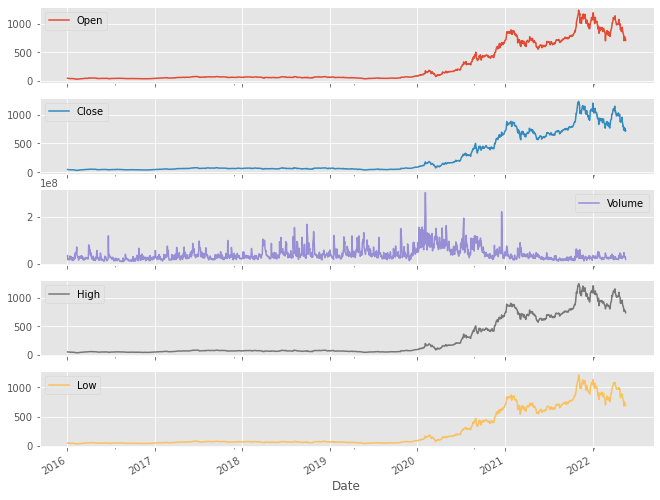

In [62]:
# Here we look at Bank of America (ticker = BAC); change ticker to view another company.
x = 'TSLA'
# Read csv file and store in dataframe

def reading_data(x):
    df = pd.read_csv('stock_dfs2/'+ x +'.csv', parse_dates = True, index_col = 'Date')

    # Moving average over 100 day period. You can alter the window to average over 30 days, or another time period.
    df['100ma'] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean()
    df.dropna(inplace = True)
    return df


train_data = reading_data(x)
plt.figure(figsize=(16, 8)) # resizing the plot
cols = ['Open', 'Close', 'Volume', 'High', 'Low']
axes = train_data[cols].plot(figsize=(11, 9), subplots = True)
plt.show()

In [63]:
train_data['HL_PCT'] = (train_data['High'] - train_data['Low']) / train_data['Low'] * 100.0
train_data['PCT_change'] = (train_data['Close'] - train_data['Open']) / train_data['Open'] * 100.0

In [64]:
train_data.isnull().sum()

High          0
Low           0
Open          0
Close         0
Volume        0
Adj Close     0
100ma         0
HL_PCT        0
PCT_change    0
dtype: int64

# Part 10: Try on single company 4 different machine learning Regressor

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import math

In [66]:
df = train_data[['HL_PCT', 'PCT_change', 'Adj Close','Volume']]
forecast_out = int(math.ceil(0.05 * len(df))) # forcasting out 5% of the entire dataset
print(forecast_out)
df['label'] = df['Adj Close'].shift(-forecast_out)

81


In [67]:
df.tail(85)

,HL_PCT,PCT_change,Adj Close,Volume,label
Date,,,,,
2022-01-19,5.996989,-4.421570,995.650024,25147500.0,724.369995
2022-01-20,4.794772,-1.333026,996.270020,23496200.0,761.609985
2022-01-21,6.810206,-5.263264,943.900024,34472000.0,709.809998
2022-01-24,9.635107,2.789689,930.000000,50521900.0,725.359985
2022-01-25,5.319913,0.459419,918.400024,28865300.0,NaN
...,...,...,...,...,...
2022-05-13,4.760697,-0.502916,769.590027,30651800.0,NaN
2022-05-16,7.046403,-5.577713,724.369995,28699500.0,NaN
2022-05-17,4.888524,1.906712,761.609985,26745400.0,NaN


In [68]:
scaler = StandardScaler()
X = np.array(df.drop(['label'], 1))
scaler.fit(X)
X = scaler.transform(X)


In [69]:
X_Predictions = X[-forecast_out:] # data to be predicted
X = X[:-forecast_out] # data to be trained
len(X)

1526

In [70]:
df.dropna(inplace=True)
y = np.array(df['label'])
len(y)

1526

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_confidence = lr.score(X_test, y_test)
lr_confidence

0.8371698751431009

In [73]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_confidence = rf.score(X_test, y_test)
rf_confidence

0.9590185189924343

In [74]:
rg = Ridge()
rg.fit(X_train, y_train)
rg_confidence = rg.score(X_test, y_test)
rg_confidence

0.837276082777475

In [75]:
svr = SVR()
svr.fit(X_train, y_train)
svr_confidence = svr.score(X_test, y_test)
svr_confidence

0.16621471155566014

In [76]:
names = ['Linear Regression', 'Random Forest', 'Ridge', 'SVR']
columns = ['model', 'accuracy']
scores = [lr_confidence, rf_confidence, rg_confidence, svr_confidence]
alg_vs_score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
alg_vs_score

,model,accuracy
0,Linear Regression,0.837170
1,Random Forest,0.959019
2,Ridge,0.837276
3,SVR,0.166215


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Ridge'),
  Text(3, 0, 'SVR')])

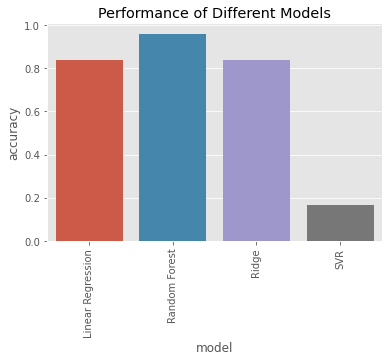

In [77]:
import seaborn as sns
sns.barplot(data = alg_vs_score, x='model', y='accuracy' )
plt.title('Performance of Different Models')
plt.xticks(rotation='vertical')

In [78]:
import datetime

last_date = df.index[-1] #getting the lastdate in the dataset
last_unix = last_date.timestamp() #converting it to time in seconds
one_day = 86400 #one day equals 86400 seconds
next_unix = last_unix + one_day # getting the time in seconds for the next day
forecast_set = rf.predict(X_Predictions) # predicting forecast data
forecast_set


array([ 891.0555011 ,  798.75320129,  665.84660095,  644.608703  ,
        800.51010376,  924.01499146,  846.42549194,  855.89139954,
        974.48170898,  881.72219238,  873.92899719,  880.87868835,
        903.57359741,  671.8185022 ,  781.16869568,  921.39499756,
        866.45759216,  769.14980896,  736.3210022 ,  685.58040283,
        729.51099426,  663.53319702,  653.96950317,  703.5061969 ,
        683.354198  ,  717.6490979 ,  734.87890747,  645.78060608,
        729.44720032,  671.03198975,  730.62450562,  708.90150391,
        757.6714032 ,  952.98900024,  760.54249634,  696.33089539,
        789.25069275,  841.21810547,  884.75729248,  856.54330383,
        843.65640198,  849.62279419,  851.71518982,  834.04879272,
        934.28818909,  884.49908691,  904.65519714,  891.66058899,
        927.45420288,  887.57018982,  826.01419434,  868.28649841,
        878.09969482,  891.86918701,  840.55679138,  913.4829071 ,
        876.76269043,  889.16510193,  892.42260559,  984.62929

In [79]:
# loop on the Forecast column to get the next day's price
df['Forecast'] = np.nan
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [80]:
df.tail()

,HL_PCT,PCT_change,Adj Close,Volume,label,Forecast
Date,,,,,,
2022-04-11 02:00:00,NaN,NaN,NaN,NaN,NaN,758.830893
2022-04-12 02:00:00,NaN,NaN,NaN,NaN,NaN,732.908596
2022-04-13 02:00:00,NaN,NaN,NaN,NaN,NaN,806.550199
2022-04-14 02:00:00,NaN,NaN,NaN,NaN,NaN,740.082798
2022-04-15 02:00:00,NaN,NaN,NaN,NaN,NaN,1042.791593


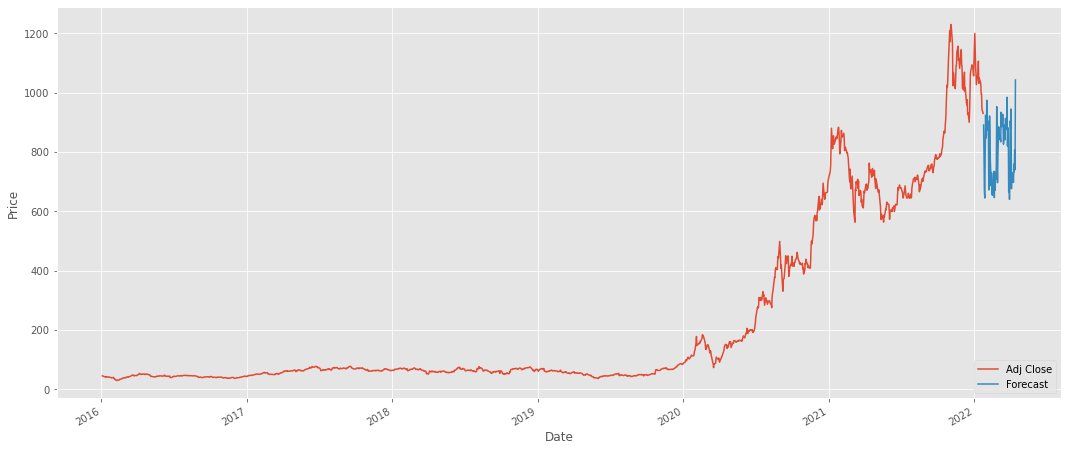

In [81]:
plt.figure(figsize=(18, 8))
df['Adj Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Part 11: Develop pipeline to try Random Forest Regressor on the entire S&P 500 dataset

In [82]:
import pandas as pd
# Develop pipeline to try Random Forest Regressor on the entire S&P 500 dataset
def pipeline():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    if tickers.count('BRK.B') > 0 or tickers.count('BF.B') > 0:
        print('Yes, proceed to remove item  BRK.B & BF.B from the list of tickers: ')
        # drop item BRK.B. from list
        tickers.remove('BRK.B')
        tickers.remove('BF.B')
        print("Removed")


    # create a dictionary to store rf confidence for every ticker
    tickers_rf_dict = {"tickers":[], "rf_confidence":[]}
    
    # Count in SP500 tickers list
    for ticker in tickers:
        df = pd.read_csv('stock_dfs2/{}.csv'.format(ticker))
        df.set_index('Date', inplace = True)
        df['100ma'] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean()
        df.dropna(inplace = True)
        df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
        df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
        
        df = df[['HL_PCT', 'PCT_change', 'Adj Close','Volume']]
        
        forecast_out = int(math.ceil(0.05 * len(df))) # forcasting out 5% of the entire dataset
        df['label'] = df['Adj Close'].shift(-forecast_out)

        scaler = StandardScaler()
        X = np.array(df.drop(['label'], 1))
        scaler.fit(X)
        X = scaler.transform(X)

        X_Predictions = X[-forecast_out:] # data to be predicted
        X = X[:-forecast_out] # data to be trained
        


        df.dropna(inplace=True)
        y = np.array(df['label'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        rf_confidence = rf.score(X_test, y_test)
        # append rf_confidence to a list
        tickers_rf_dict["tickers"].append(ticker)
        tickers_rf_dict["rf_confidence"].append(rf_confidence)
        #print(ticker + ': ' + str(rf_confidence))

    l = pd.DataFrame(tickers_rf_dict)
    return l
rf_confidence = pipeline()

Yes, proceed to remove item  BRK.B & BF.B from the list of tickers: 
Removed


In [83]:
# mean of the datafram l
rf_confidence.mean()

rf_confidence    0.759636
dtype: float64

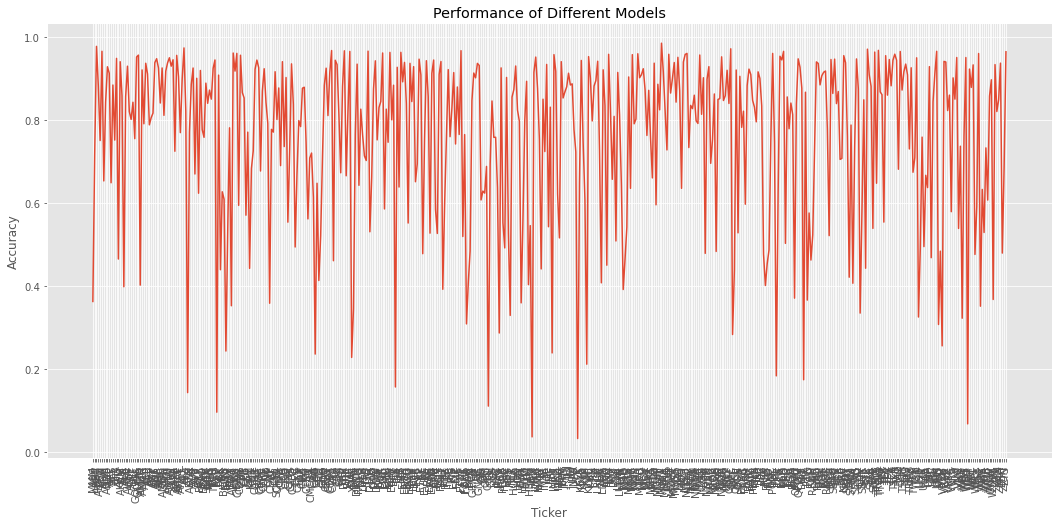

In [84]:
# plot the dataframe l and hide the x axis labels
plt.figure(figsize=(18, 8))
plt.plot(rf_confidence['tickers'], rf_confidence['rf_confidence'])
plt.xticks(rotation='vertical')
plt.title('Performance of Different Models')
plt.xlabel('Ticker')
plt.ylabel('Accuracy')
plt.show()


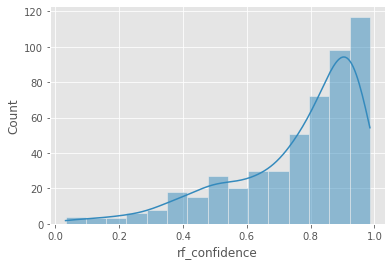

In [85]:

sns.histplot(rf_confidence['rf_confidence'], kde=True); # kde: Whether to plot a gaussian kernel density estimate.